In [1]:
### Let's build a convolutional neural network for the 3-label classification ###

In [2]:
# import modules
import pandas as pd
import numpy as np
import cv2 as cv
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

2023-01-24 22:48:12.160265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 22:48:13.826129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-24 22:48:13.826819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/si

In [3]:
### Load the 3-class dataset
data = pd.read_csv('../eda/data_3_targets.csv')
data

,image_id,age_approximate,sex,melanoma,seborrheic_keratosis,neither,red_mode,green_mode,blue_mode,red_median,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,ISIC_0000000,55,female,0,0,1,65,51,57,94,...,5.098648,0.109615,2.625431,0.508180,11.428232,10.780367,0.012018,0.329654,0.006513,0.046969
1,ISIC_0000001,30,female,0,0,1,87,53,46,116,...,4.441031,0.140831,2.777913,0.575211,2.318644,4.577623,0.021560,0.808480,0.006020,0.124740
2,ISIC_0000002,60,female,1,0,0,162,120,114,161,...,2.709728,0.168455,1.932127,0.540123,2.526498,0.231924,0.547760,0.007574,0.000012,0.941026
3,ISIC_0000003,30,male,0,0,1,182,128,51,161,...,2.581140,0.216727,2.214528,0.542617,2.665591,3.318969,0.040507,0.119264,0.000637,0.080628
4,ISIC_0000004,80,male,1,0,0,192,132,171,192,...,18.402358,0.129868,4.275156,0.564438,2.312946,0.506435,0.043551,3.153283,0.021736,2.213424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ISIC_0015220,75,male,0,1,0,120,36,20,136,...,3.702858,0.155806,4.435975,0.188760,213.351940,11.504115,0.014350,0.271341,0.005850,0.070004
1996,ISIC_0015233,60,male,0,1,0,71,124,101,115,...,4.671226,0.112319,3.028206,0.536858,2.644843,11.205961,0.007821,0.237932,0.001880,0.042187
1997,ISIC_0015260,55,female,0,1,0,76,21,13,77,...,2.564094,0.197151,4.190389,0.181698,164.827636,8.735373,0.009154,0.904079,0.002138,0.132170
1998,ISIC_0015284,75,male,1,0,0,136,19,6,143,...,11.609996,0.069719,4.160087,0.526389,5.469382,2.553310,0.009927,2.045905,0.003094,0.333450


In [4]:
# diagnostic column:
## 0 - neither, 1 - melanoma, 2 - seborrheic keratosis, 
for i,u in enumerate(data['image_id']):
    if data.loc[i,'melanoma'] == 0:
        if data.loc[i,'seborrheic_keratosis'] == 1:
            data.loc[i,'melanoma'] = 2
    else:
        continue      
data.drop(columns=['seborrheic_keratosis', 'neither'], inplace=True)

In [5]:
targets = pd.DataFrame(data[['image_id','melanoma']])

In [6]:
targets

,image_id,melanoma
0,ISIC_0000000,0
1,ISIC_0000001,0
2,ISIC_0000002,1
3,ISIC_0000003,0
4,ISIC_0000004,1
...,...,...
1995,ISIC_0015220,2
1996,ISIC_0015233,2
1997,ISIC_0015260,2
1998,ISIC_0015284,1


In [7]:
## Get images array and add to DataFrame
## image array shape (image, width, height, rgb)

path = '../../segmented/SEG'
X = []
Y = []
for i in targets['image_id']:
    clear_output(wait=True)
    impath = path + i + '.jpg'
    im = cv.imread(impath, -1)
    im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    # augment data through flipping
    im_flipped_0 = cv.flip(im_rgb,0)
    X.append(im_rgb)
    Y.append(targets[targets['image_id']==i]['melanoma'].item())
  
    X.append(im_flipped_0)
    Y.append(targets[targets['image_id']==i]['melanoma'].item())    

In [8]:
X = np.array(X)
np.shape(X)

(4000, 150, 150, 3)

In [9]:
# [1., 0., 0.] - neither, [0., 1., 0.] melanoma, [0., 0., 1.] keratosis
Y = to_categorical(Y, num_classes=3)
Y

# normalize pixel values
X = (X-127.5) / 127.5

In [10]:
# Neural network structure

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 146, 146, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 50)        40050     
                                                                 
 batch_normalization_1 (Batc  (None, 69, 69, 50)       200       
 hNormalization)                                                 
                                                        

2023-01-24 22:48:21.852820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-24 22:48:21.852858: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-24 22:48:21.853334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other op

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)

In [12]:
optimizer = Adam(lr=0.001)

/home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['acc'])

Epoch 1/5


2023-01-24 22:48:23.949196: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 972000000 exceeds 10% of free system memory.


360/360 [==============================] - 273s 757ms/step - loss: 1.5617 - acc: 0.6789 - val_loss: 11.7427 - val_acc: 0.3400
Epoch 2/5
360/360 [==============================] - 279s 775ms/step - loss: 0.8443 - acc: 0.6853 - val_loss: 106.5976 - val_acc: 0.2925
Epoch 3/5
360/360 [==============================] - 270s 751ms/step - loss: 0.7901 - acc: 0.6853 - val_loss: 35.1847 - val_acc: 0.2925
Epoch 4/5
360/360 [==============================] - 268s 745ms/step - loss: 0.7733 - acc: 0.6853 - val_loss: 70.8013 - val_acc: 0.3100
Epoch 5/5
360/360 [==============================] - 245s 682ms/step - loss: 0.7667 - acc: 0.6853 - val_loss: 5.7777 - val_acc: 0.6225


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


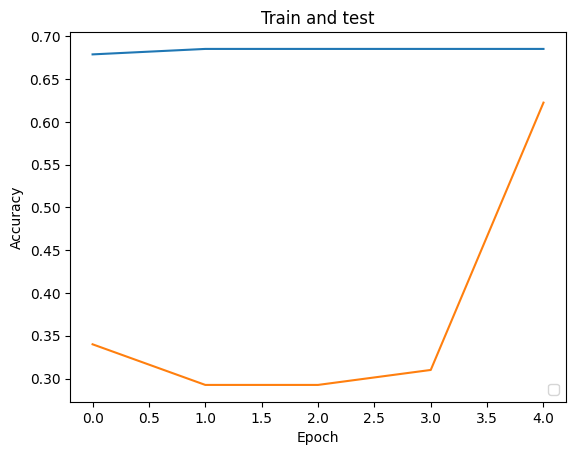

In [14]:
h = model.fit(X_train, y_train, batch_size=10, epochs=5, validation_data=(X_test, y_test))

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title("Train and test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')